In [1]:
from scipy.io.wavfile import read as wav_read
import numpy as np
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt
import math
from scipy.signal import spectrogram

%matplotlib inline

In [2]:
def normalize(wave):
    def unbias(wave):
        return wave - wave.mean()
    wave = unbias(wave)
    return wave / np.max(np.abs(wave))

# Загрузка файла

In [3]:
# rate, wave = wav_read('./kuznechik_short.wav')
rate, wave = wav_read('./katusha_long.wav')
wave = normalize(wave)
length = wave.shape[0] / rate
cnt = 100

In [4]:
wave.shape

(1021323,)

In [5]:
rate

44100

In [6]:
length

23.159251700680272

In [7]:
def time_to_wi(time, rate):
    return (time * rate).astype(int)

In [8]:
def wi_to_time(wi, rate):
    return wi / rate

# Поиск тишины

In [9]:
cnt_per_sec = 10
VOLUME_FOR_SILENCE = 0.03

def est1(seg):
    return np.mean(np.abs(seg))

def get_silence(wave):
    segs_num = int(length * cnt_per_sec)
    is_silence = np.zeros(shape=segs_num)
    for i in range(segs_num):
        s1 = rate * i // cnt_per_sec
        s2 = rate * (i + 1) // cnt_per_sec
        vol = est1(wave[s1:s2])
        is_silence[i] = 1 if vol > VOLUME_FOR_SILENCE else 0
    return is_silence
# разбивает wave на отрезки длины cnt_per_sec и 
# если средняя громкость на отрезке больше VOLUME_FOR_SILENCE, то считаем, что на отрезке молчание


In [10]:
MIN_SEGMENT_LENGTH = 1

def eject_list_of_segments_silenceless(oldwave):
    old_silence_mask = get_silence(wave)
    silence_mask = np.concatenate(([0], old_silence_mask, [0]))
    
    d = silence_mask[1:] - silence_mask[:-1]
   
    start = np.argwhere(d > 0).ravel()
    stop  = np.argwhere(d < 0).ravel()
    
    segments = []
    pauses_lens = [0.5]
    for i in np.arange(start.shape[0]):
        new_part = wave[time_to_wi(start[i] / cnt_per_sec, rate) : time_to_wi(stop[i] / cnt_per_sec, rate)]
        if len(new_part) > MIN_SEGMENT_LENGTH:
            segments.append(new_part)
            pauses_lens.append(0.0)
        if i < len(start) - 1:
            pauses_lens[len(pauses_lens) - 1] += (start[i + 1]  - stop[i]) / cnt_per_sec
    return start / cnt_per_sec, stop / cnt_per_sec, pauses_lens
# возвращает начала, концы, отрезков не с тишиной (в секундах)
# длины пауз

In [11]:
seg_starts, seg_stops, pauses_lens = eject_list_of_segments_silenceless(wave)
print((seg_starts))
print((seg_stops))
print((pauses_lens))

[ 0.4  6.4 12.  18.  23. ]
[ 5.9 11.3 17.5 22.3 23.1]
[0.5, 0.5, 0.7, 0.5, 0.7, 0.0]


# Автокорреляция

In [12]:
def run_ps(*args):
    sp.ru41n(args, check=True)

In [13]:
def show(ys):
    ts = np.arange(ys.shape[0])
    plt.figure(figsize=(15, 6))
    plt.plot(ts, ys)

In [14]:
def determine(left, right):
    base = 440
    i1 = math.log(left / base) / math.log(2) * 12
    i2 = math.log(right / base) / math.log(2) * 12
    i1 = math.ceil(i1)
    i2 = math.floor(i2)
    return i1

In [15]:
def get_pitch(wave, pos, length):
    try:
        wave = wave[pos:]
        wave = wave[:int(length / cnt * rate)]

        nwave = np.zeros(shape=wave.shape[0] * 2)
        nwave[:wave.shape[0]] = wave
        window = np.flipud(nwave)

        corr = ifft(fft(nwave) * fft(window)).real
        n = corr.shape[0]
        corr = np.roll(corr, n)[:n]

        corr = corr[:corr.shape[0] // 2]
        diff = np.diff(corr)
        maxs = np.argwhere(np.logical_and(diff[:-1] > 0, diff[1:] < 0)).squeeze()
        maxs = maxs[np.argwhere(corr[maxs] > 0.95 * corr[maxs].max()).squeeze()]
        if len(maxs.shape) == 0:
            ind = int(maxs)
        else:
            ind = maxs[0]

        if ind == 1:
            show(corr)
        return rate / (ind + 2), rate / (ind if ind != 0 else 1)
    except Exception as e:
        return 1, 10
#     выцепляет основную мелодию
#  хотим выцепить самую яркую волну с картинки
# возвращает диапазон частот с самой большой корреляцией
    

In [16]:
def show_results(wave, rate, predict):
    predict = np.asanyarray(predict)
    wave = np.asanyarray(wave)
    fs, ts, sxx = spectrogram(wave, rate, nperseg=4096 * 2, noverlap=4096 * 2 * 7 // 8) 
    plt.figure(figsize=(15, 6))
    plt.pcolormesh(ts, fs[:256], np.log(sxx[:256, :]))
    plt.plot(np.arange(0, len(predict) / cnt, 1 / cnt), 440 * 2 ** (predict / 12), color='black')
    plt.ylim(0, 4096 / 4)
    plt.show()

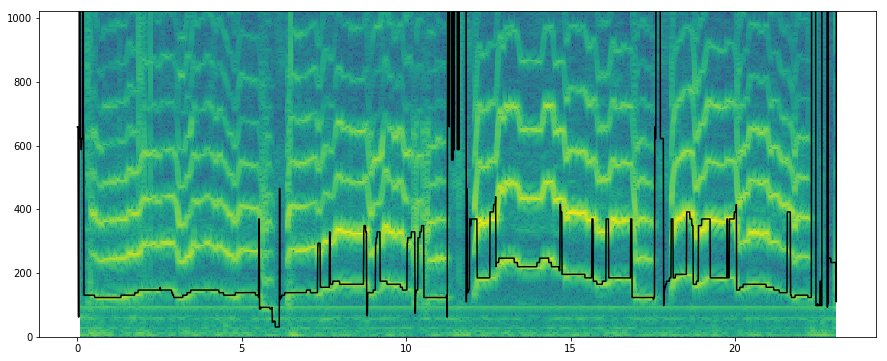

In [17]:
res = []
for pos in np.arange(0, length - 1 / cnt, 1 / cnt):
    pitch = get_pitch(wave, int(pos * rate), length)
    det = determine(*pitch)
    res.append(det)
show_results(wave, rate, res)
# бежит по wave раскладывает на ноты функцией det
# рисует
# res - чёрная линия то что нужно

# Фильтрация

In [18]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, 'same')
# скользящее среднее - сглаживаем пики

In [19]:
def show_results_filtered(wave, rate, predict, correcteddata, times):
    predict = np.asanyarray(predict)
    wave = np.asanyarray(wave)
    fs, ts, sxx = spectrogram(wave, rate, nperseg=4096 * 2, noverlap=4096 * 2 * 7 // 8)
    plt.figure(figsize=(15, 6))
    plt.pcolormesh(ts, fs[:256], np.log(sxx[:256, :]))
    plt.plot(np.arange(0, len(predict) / cnt, 1 / cnt), 440 * 2 ** (predict / 12), color='black')
    plt.plot(times, 440 * 2 ** (predict / 12), color='black')
    plt.plot(times, 440 * 2 ** (correcteddata / 12), color='blue')
    
    plt.ylim(0, 1000)
    plt.show()
#     функция отрисовки рисует как на графике выше

In [20]:
PEAK_FACTOR = 0.5
MAX_PEAK_LENGTH = 50

def filter_lunges_in_segment(olddata, times):
    
    data = olddata[:]

    smooth_data = movingaverage(data, np.minimum(70, len(data))) #UnivariateSpline(times, data.ravel(), s=0.05)(times)
    i = 1
    places = []
    while i < len(data):
        j = 0
        if np.abs(data[i] - smooth_data[i]) > PEAK_FACTOR * np.abs(smooth_data[i]):
            last_sign = data[i] - smooth_data[i-1]
            places.append(i)
            delta = data[i] - data[i-1]
            start_value = data[i-1]
            while j < MAX_PEAK_LENGTH and i + j < len(data) :                
                if (not (np.abs(data[i+j] - smooth_data[i+j]) > PEAK_FACTOR * np.abs(smooth_data[i+j]))) \
                or (data[i+j] - smooth_data[i+j]) * last_sign < 0:
                    break
                data[i+j] -= delta
                j += 1
        i = i + j + 1    
    
    print(len(data))
    print(len(olddata))
    
    return data
# ищет промежутки в которых мелодия резко скачет вверх/ Ищет момент когда высота звука отличаертся от сильно сглаенного больше
# больше чем в 0.5 раз то с этого момента начинаем насчитывать "длину" выброса/ Если она больше пороговой то считаем что мелодия такая
#  если меньше то выравниваем

In [21]:
SILENCE_CONST = -1707

def filter_all_segments(predict, seg_starts, seg_stops, pauses):

    times = np.arange(0, len(predict) / cnt, 1 / cnt)
    pr_len = len(predict)
    
    
    near_notes = np.array(predict[:])
    
    start = (seg_starts * cnt).astype(int)
    stop = (seg_stops * cnt).astype(int)
    
    tmp1 = start[0] - 1 if start[0] > 0 else 0
    tmp2 = (stop[len(stop) - 1] + 1 if start[0] > 0 else 0)
    near_notes[:tmp1] = SILENCE_CONST
    near_notes[tmp2:] = SILENCE_CONST
    for i in np.arange(len(start)):
        l = start[i]
        r = stop[i]
        if (i > 0):
             near_notes[stop[i-1] : start[i]] = SILENCE_CONST  
        near_notes[l:r] = filter_lunges_in_segment(predict[l:r], times[l:r])
    return near_notes
# перебирает отрезки, полученные в функции eject list of segments   и нетишину фильтрует

550
550
490
490
550
550
430
430
10
10


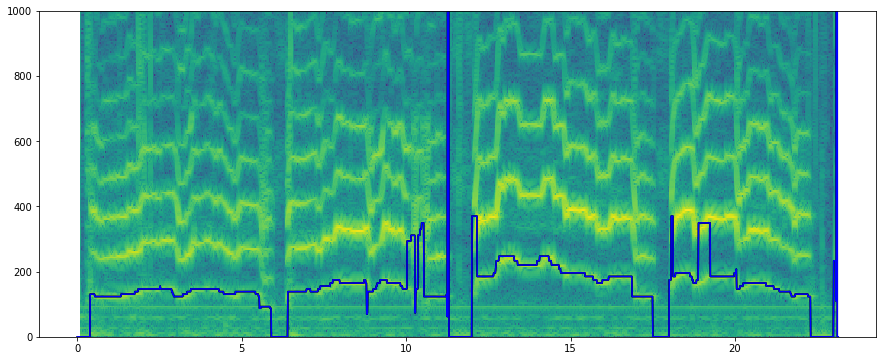

In [22]:
corrected_notes = filter_all_segments(res, seg_starts, seg_stops, pauses_lens)
show_results_filtered(wave, rate, corrected_notes, corrected_notes, np.arange(0, len(corrected_notes) / cnt, 1 / cnt))

# Восстановление кусочно-постоянной функции

In [23]:
def k_means_2(seg, k):
    segs = [(i, i + 1) for i in range(len(seg))]
    for i in range(len(seg) - k + 1):
        mval = 1e10
        pos = -1
        for j in range(len(segs) - 1):
            u1, u2 = segs[j]
            v1, v2 = segs[j + 1]
            m1 = np.median(seg[u1:u2])
            m2 = np.median(seg[v1:v2])
            if mval > abs(m1 - m2):
                mval = abs(m1 - m2)
                pos = j
        segs[pos] = (segs[pos][0], segs[pos + 1][1])
        del segs[pos + 1]
    return segs
# алгоритм агломеративной кластеризации(unsupervized learning)
# на каждой итерации склеивает два маленьких соседних отрезка с минимальной разницей медиан
# пока отрезков не останется k штук (NOTES_PER_PHRASE - эмперической величины)

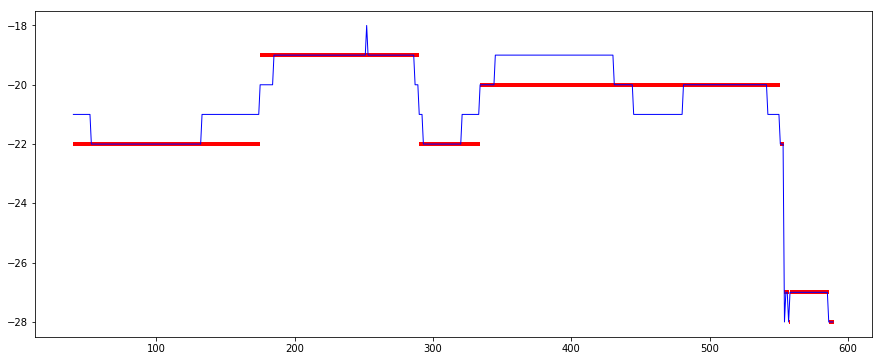

550


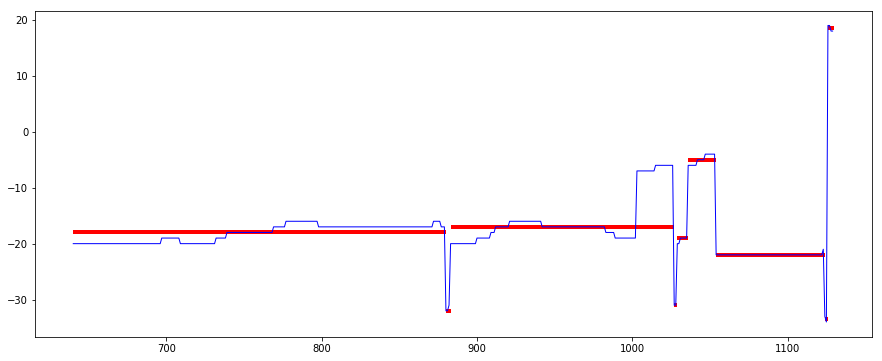

490


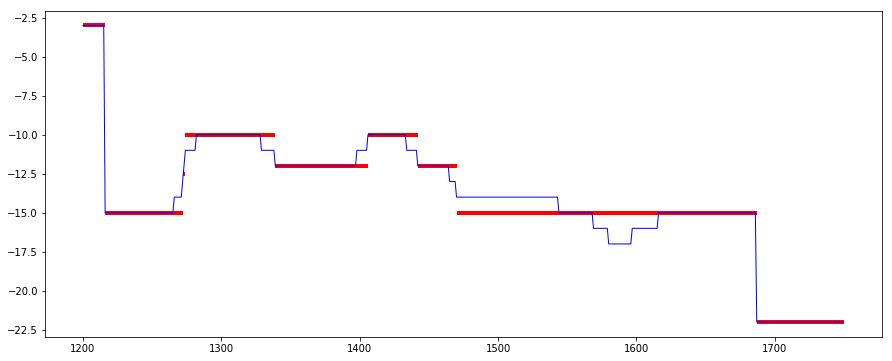

550


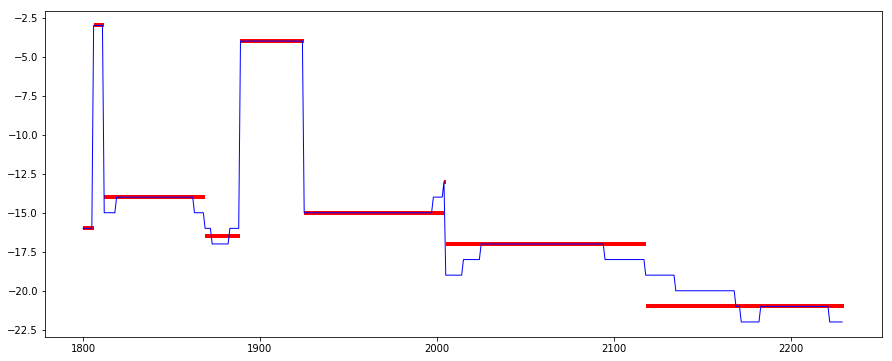

430


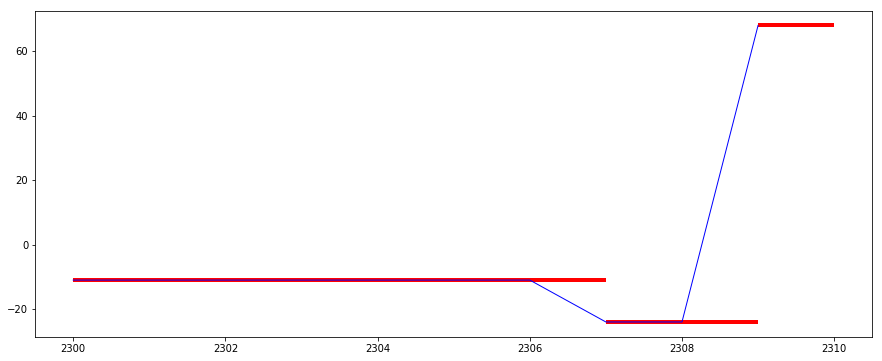

10


In [24]:
MIN_NOTE_LENGTH = 0.1 # secs
NOTES_PER_PHRASE = 10

start = (seg_starts * cnt).astype(int)
stop = (seg_stops * cnt).astype(int)

plt.figure(figsize=(15, 7))

all_segments = []

for i in np.arange(len(start)):
    seg = corrected_notes[start[i]:stop[i]]
    
    kmeans_notes = k_means_2(seg, k=NOTES_PER_PHRASE)
    
    plt.figure(figsize=(15, 6))
    plt.plot(np.arange(len(corrected_notes))[start[i]:stop[i]], seg, color='blue', lw=1)
    for u, v in kmeans_notes:
        if (v - u) / cnt > 0:#MIN_NOTE_LENGTH: раскоментить если нужно выбрасывать короткие звуки
            all_segments.append((u + start[i], v + start[i], np.median(seg[u:v])))
            plt.hlines(np.median(seg[u:v]), u + start[i], v + start[i], color='red', lw=4)
    
    #plt.ylim(0, 100)
    #plt.xlim((11, 20))
    plt.show()
    
    print(len(seg))
#  

In [25]:
all_segments

[(40, 175, -22.0),
 (175, 290, -19.0),
 (290, 334, -22.0),
 (334, 551, -20.0),
 (551, 554, -22.0),
 (554, 557, -27.0),
 (557, 558, -28.0),
 (558, 586, -27.0),
 (586, 590, -28.0),
 (640, 880, -18.0),
 (880, 883, -32.0),
 (883, 1027, -17.0),
 (1027, 1029, -31.0),
 (1029, 1036, -19.0),
 (1036, 1054, -5.0),
 (1054, 1124, -22.0),
 (1124, 1126, -33.5),
 (1126, 1130, 18.5),
 (1200, 1216, -3.0),
 (1216, 1272, -15.0),
 (1272, 1274, -12.5),
 (1274, 1339, -10.0),
 (1339, 1406, -12.0),
 (1406, 1442, -10.0),
 (1442, 1470, -12.0),
 (1470, 1687, -15.0),
 (1687, 1750, -22.0),
 (1800, 1806, -16.0),
 (1806, 1812, -3.0),
 (1812, 1869, -14.0),
 (1869, 1889, -16.5),
 (1889, 1925, -4.0),
 (1925, 2004, -15.0),
 (2004, 2005, -13.0),
 (2005, 2118, -17.0),
 (2118, 2230, -21.0),
 (2300, 2302, -11.0),
 (2302, 2303, -11.0),
 (2303, 2304, -11.0),
 (2304, 2305, -11.0),
 (2305, 2306, -11.0),
 (2306, 2307, -11.0),
 (2307, 2308, -24.0),
 (2308, 2309, -24.0),
 (2309, 2310, 68.0)]

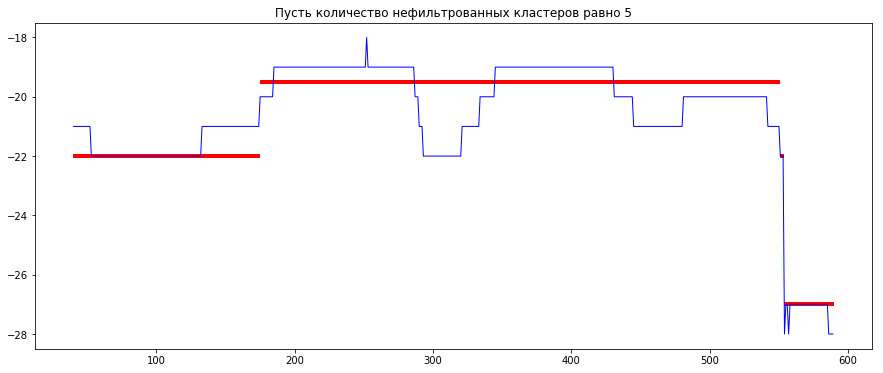

550


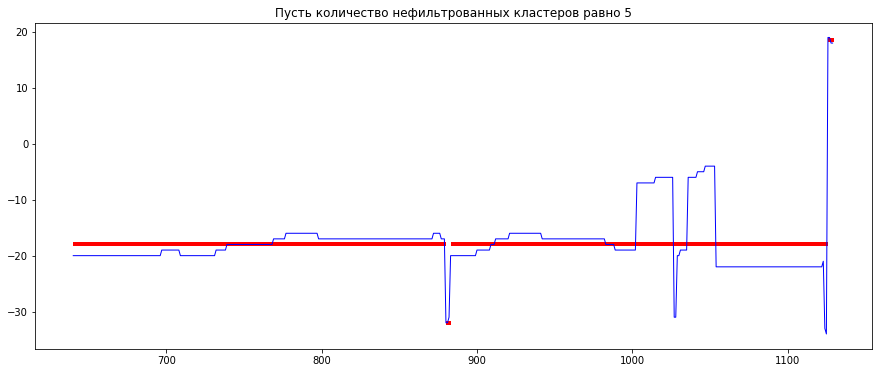

490


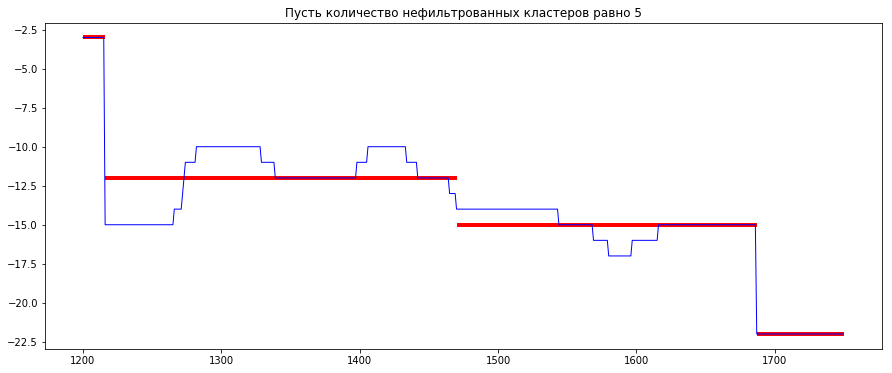

550


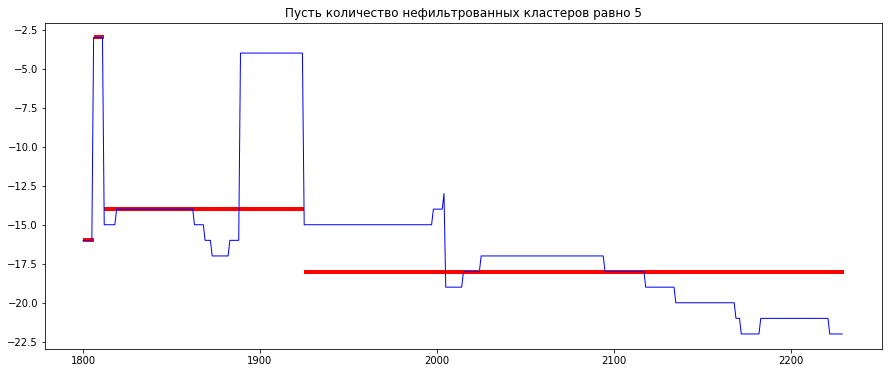

430


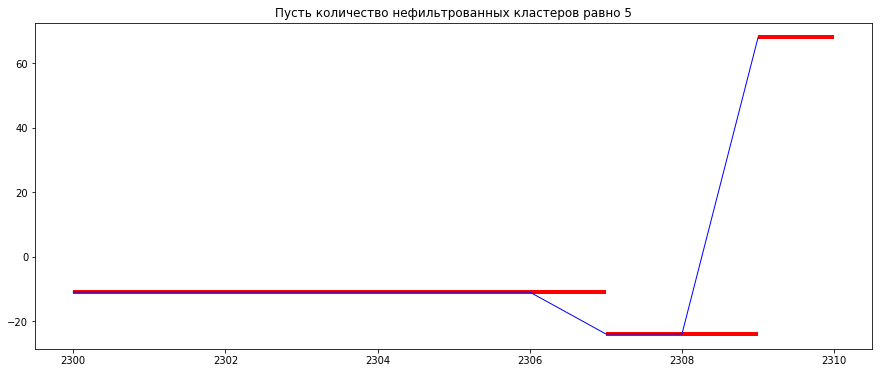

10


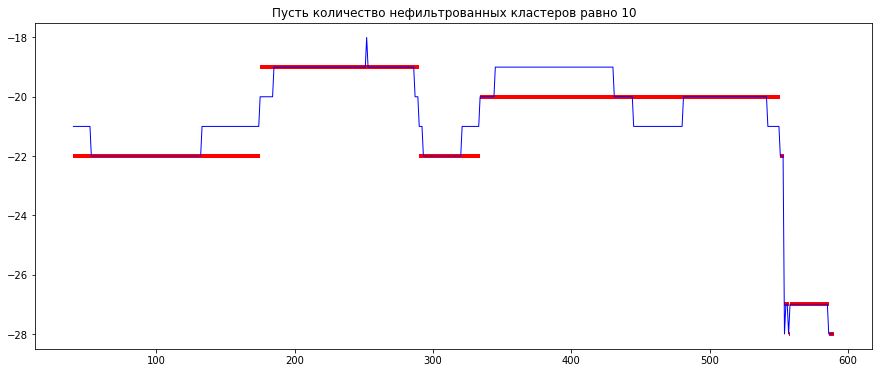

550


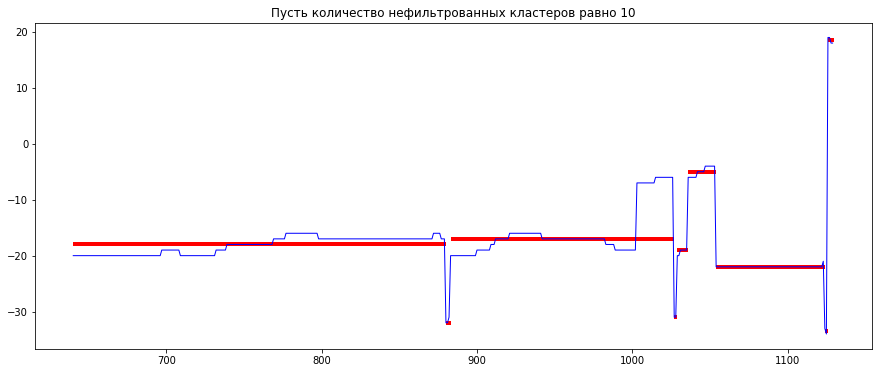

490


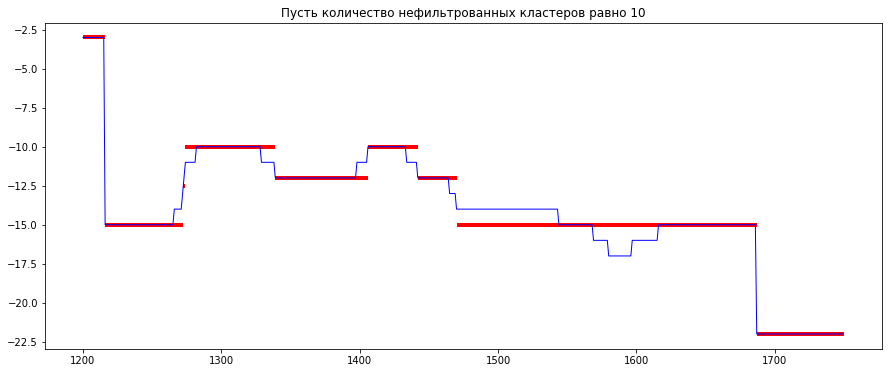

550


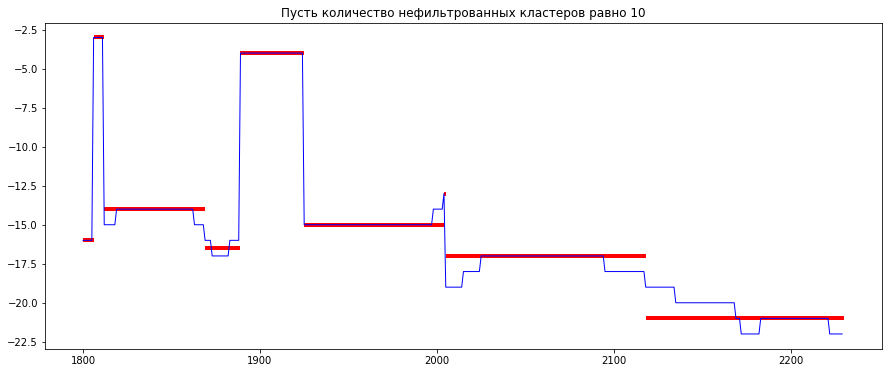

430


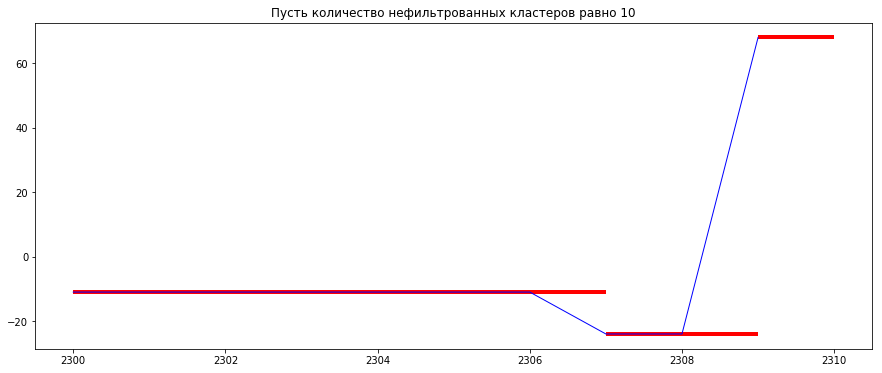

10


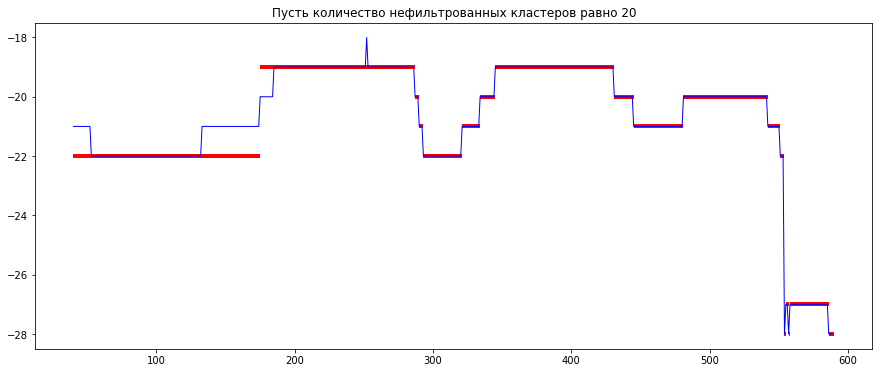

550


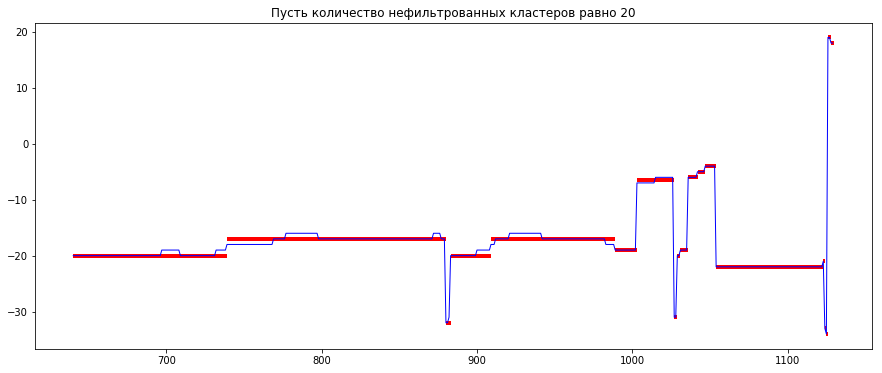

490


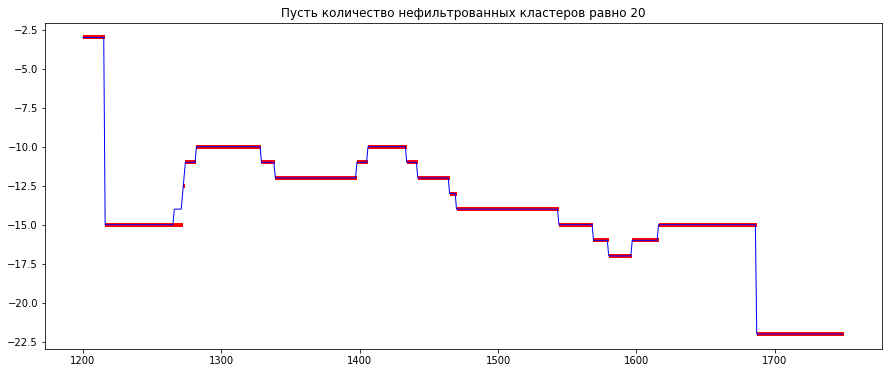

550


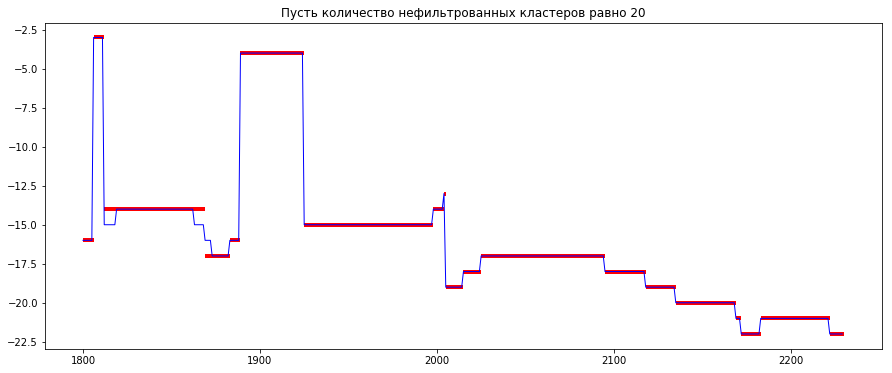

430


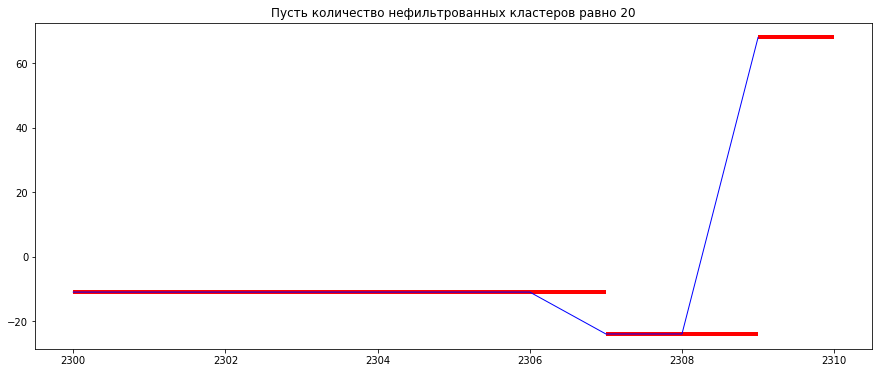

10


In [27]:
MIN_NOTE_LENGTH = 0.1 # secs
for NOTES_PER_PHRASE in [5, 10, 20]:

    start = (seg_starts * cnt).astype(int)
    stop = (seg_stops * cnt).astype(int)

    plt.figure(figsize=(15, 7))

    all_segments = []

    for i in np.arange(len(start)):
        seg = corrected_notes[start[i]:stop[i]]

        kmeans_notes = k_means_2(seg, k=NOTES_PER_PHRASE)

        plt.figure(figsize=(15, 6))
        plt.plot(np.arange(len(corrected_notes))[start[i]:stop[i]], seg, color='blue', lw=1)
        for u, v in kmeans_notes:
            if (v - u) / cnt > 0:#MIN_NOTE_LENGTH: раскоментить если нужно выбрасывать короткие звуки
                all_segments.append((u + start[i], v + start[i], np.median(seg[u:v])))
                plt.hlines(np.median(seg[u:v]), u + start[i], v + start[i], color='red', lw=4)

        #plt.ylim(0, 100)
        #plt.xlim((11, 20))
        plt.title('Пусть количество нефильтрованных кластеров равно {}'.format(NOTES_PER_PHRASE))
        plt.show()

        print(len(seg))
    #  